In [117]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Load datasets
train_df = pd.read_csv("/train.csv")
test_df = pd.read_csv("/test.csv")




In [118]:
# 2. Normalize columns
train_df.columns = train_df.columns.str.lower().str.strip()
test_df.columns = test_df.columns.str.lower().str.strip()


In [119]:
# 3. Encode categorical features
categoricals = ['gender', 'vehicle_age', 'vehicle_damage']
encoders = {col: LabelEncoder().fit(train_df[col]) for col in categoricals}

for col, encoder in encoders.items():
    train_df[col] = encoder.transform(train_df[col])
    test_df[col] = encoder.transform(test_df[col])

In [120]:
# 4. Select features for ML models
features = ['age', 'vehicle_age', 'vehicle_damage', 'previously_insured',
            'annual_premium', 'policy_sales_channel', 'vintage']

X = train_df[features]
y_class = train_df['response']  # For classification
y_regr = train_df['annual_premium']  # Optional for regression


In [136]:
# 5. Train Risk Classifier (Random Forest)
X_train, X_test_split, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_class_train)

# Optional: Train Regression Model (if you want ML pricing)
X_train_regr, X_test_regr, y_regr_train, y_regr_test = train_test_split(X, y_regr, test_size=0.2, random_state=42)

reg = GradientBoostingRegressor(n_estimators=100, random_state=42)
reg.fit(X_train_regr, y_regr_train)

GradientBoostingRegressor(random_state=42)

In [137]:
# 6. Predict Risk Score on test set
X_test = test_df[features]
test_df['risk_score'] = clf.predict_proba(X_test)[:, 1]
test_df['base_premium'] = reg.predict(X_test)

In [138]:
# 7. Add market index simulation
np.random.seed(42)
test_df['market_index'] = np.random.normal(loc=1.0, scale=0.05, size=len(test_df))


In [139]:
# 8. Final Premium Calculation
def calculate_final_premium(base_premium, market_index, risk_score):
    adjusted = base_premium * market_index
    final = round(adjusted * (1 + 0.1 * risk_score), 2)  # Risk factor weighted more
    return final, adjusted


In [140]:
print(results.columns)
print(results.head())


Index(['final_premium', 'risk_score', 'premium_explanation'], dtype='object')
   final_premium  risk_score  \
0       36590.53        0.00   
1       35108.32        0.48   
2       43783.85        0.62   
3       40290.81        0.01   
4       58146.30        0.00   

                                 premium_explanation  
0  Base: $35703.80, Market Index: 1.02 → Adj: $36...  
1  Base: $33733.51, Market Index: 0.99 → Adj: $33...  
2  Base: $39934.48, Market Index: 1.03 → Adj: $41...  
3  Base: $37402.32, Market Index: 1.08 → Adj: $40...  
4  Base: $58835.13, Market Index: 0.99 → Adj: $58...  


In [141]:
test_df = test_df.drop(columns=['final_premium', 'risk_score', 'premium_explanation'], errors='ignore')


In [144]:
test_df['risk_score'] = clf.predict_proba(test_df[features])[:, 1]


In [145]:
print(test_df.columns)  # Check if 'risk_score' is there


Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'market_index', 'base_premium',
       'risk_score'],
      dtype='object')


In [146]:
def generate_quote(row):
    try:
        base = float(row['base_premium'])
        market = float(row['market_index'])
        risk = float(row['risk_score'])
    except KeyError as e:
        print(f"Missing column in row: {e}")
        print(row)
        raise

    adjusted = base * market
    final = round(adjusted * (1 + 0.1 * risk), 2)

    return pd.Series({
        "final_premium": final,
        "risk_score": round(risk, 2),
        "premium_explanation": (
            f"Base: ${base:.2f}, Market Index: {market:.2f} → "
            f"Adj: ${adjusted:.2f}, Risk Adj: +{round(0.1 * risk * 100)}% → "
            f"Final: ${final:.2f}"
        )
    })


In [147]:
# Predict risk score and base premium
test_df['risk_score'] = clf.predict_proba(test_df[features])[:, 1]
test_df['base_premium'] = reg.predict(test_df[features])

# Simulate market index
test_df['market_index'] = np.random.normal(loc=1.0, scale=0.05, size=len(test_df))

# Generate quote safely
results = test_df.apply(generate_quote, axis=1)

# Merge results into test_df
for col in results.columns:
    test_df[col] = results[col]

# Display output
display_cols = ['id', 'final_premium', 'risk_score', 'premium_explanation']
print(test_df[display_cols].head(10).to_string(index=False))


    id  final_premium  risk_score                                                                    premium_explanation
381110       31155.05        0.00 Base: $35703.80, Market Index: 0.87 → Adj: $31155.05, Risk Adj: +0% → Final: $31155.05
381111       35011.45        0.48 Base: $33733.51, Market Index: 0.99 → Adj: $33407.88, Risk Adj: +5% → Final: $35011.45
381112       46825.08        0.62 Base: $39934.48, Market Index: 1.10 → Adj: $44091.41, Risk Adj: +6% → Final: $46825.08
381113       39012.16        0.01 Base: $37402.32, Market Index: 1.04 → Adj: $38973.19, Risk Adj: +0% → Final: $39012.16
381114       60027.12        0.00 Base: $58835.13, Market Index: 1.02 → Adj: $60027.12, Risk Adj: +0% → Final: $60027.12
381115       38967.05        0.00 Base: $40170.98, Market Index: 0.97 → Adj: $38967.05, Risk Adj: +0% → Final: $38967.05
381116       37001.19        0.00 Base: $40170.98, Market Index: 0.92 → Adj: $37001.19, Risk Adj: +0% → Final: $37001.19
381117       23943.33        0.0

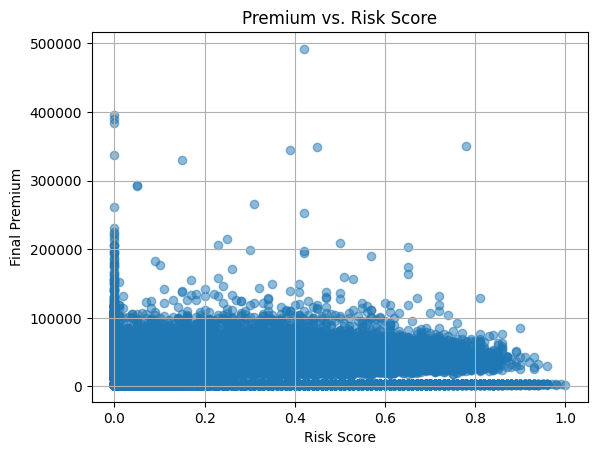

In [148]:
import matplotlib.pyplot as plt

plt.scatter(test_df['risk_score'], test_df['final_premium'], alpha=0.5)
plt.xlabel('Risk Score')
plt.ylabel('Final Premium')
plt.title('Premium vs. Risk Score')
plt.grid(True)
plt.show()


In [149]:
print(test_df[['final_premium', 'risk_score']].describe())


       final_premium     risk_score
count  127037.000000  127037.000000
mean    30917.885403       0.123027
std     17312.110787       0.182999
min      2142.630000       0.000000
25%     24370.210000       0.000000
50%     31940.630000       0.010000
75%     40037.560000       0.200000
max    491943.210000       1.000000


In [150]:
print(test_df[['id', 'risk_score', 'final_premium', 'premium_explanation']].sample(5).to_string(index=False))


    id  risk_score  final_premium                                                                    premium_explanation
430059        0.04       27544.50 Base: $27443.67, Market Index: 1.00 → Adj: $27434.76, Risk Adj: +0% → Final: $27544.50
416275        0.00       29150.67 Base: $32426.59, Market Index: 0.90 → Adj: $29150.67, Risk Adj: +0% → Final: $29150.67
491357        0.07       52916.93 Base: $54268.34, Market Index: 0.97 → Adj: $52549.08, Risk Adj: +1% → Final: $52916.93
460665        0.00        2781.46    Base: $2642.72, Market Index: 1.05 → Adj: $2781.46, Risk Adj: +0% → Final: $2781.46
483972        0.34       40247.40 Base: $41066.88, Market Index: 0.95 → Adj: $38923.98, Risk Adj: +3% → Final: $40247.40


In [151]:
from sklearn.metrics import accuracy_score

# 1. Split train data (already loaded and preprocessed above)
X_train, X_val, y_train, y_val = train_test_split(X, y_class, test_size=0.2, random_state=42)

# 2. Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 3. Predict on validation set
y_pred = clf.predict(X_val)

# 4. Evaluate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.8570


In [153]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.96      0.92     66699
           1       0.34      0.16      0.22      9523

    accuracy                           0.86     76222
   macro avg       0.62      0.56      0.57     76222
weighted avg       0.82      0.86      0.83     76222



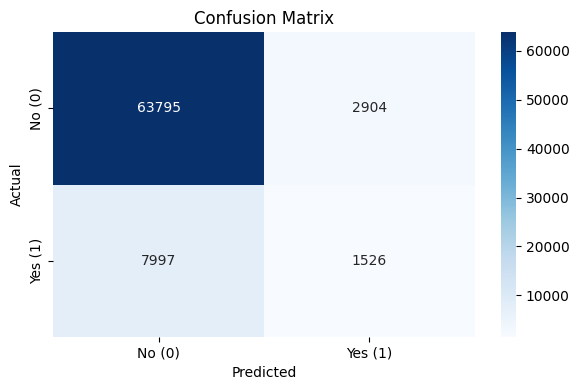

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)
labels = ['No (0)', 'Yes (1)']

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
